In [40]:
import cvxpy as cp
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt


class SyntheticControl:
    def __init__(self, data, metric, period_index, shopno, treated, after_treatment, bootstrap_rounds=100, seed=42, intercept=False):
        self.data = data.copy()
        self.metric = metric
        self.period_index = period_index
        self.shopno = shopno
        self.treated = treated
        self.after_treatment = after_treatment
        self.bootstrap_rounds = bootstrap_rounds
        self.seed = seed
        self.intercept = intercept

    def make_random_placebo(self):
        control = self.data.query(f"~{self.treated}")
        shopnos = control[self.shopno].unique()
        placebo_shopno = np.random.choice(shopnos)
        return control.assign(**{self.treated: control[self.shopno] == placebo_shopno})


    def synthetic_control(self, data=None):
        if data is None:
            data = self.data

        x_pre_control = (data
                         .query(f"not {self.treated}")
                         .query(f"not {self.after_treatment}")
                         .pivot(index=self.period_index, columns=self.shopno, values=self.metric)
                         .values)

        y_pre_treat_mean = (data
                            .query(f"not {self.after_treatment}")
                            .query(f"{self.treated}")
                            .groupby(self.period_index)[self.metric]
                            .mean())

        w = cp.Variable(x_pre_control.shape[1])
        if self.intercept:
            a = cp.Variable()
            objective = cp.Minimize(cp.sum_squares(a + x_pre_control @ w - y_pre_treat_mean.values))
        else:
            objective = cp.Minimize(cp.sum_squares(x_pre_control @ w - y_pre_treat_mean.values))
        constraints = [cp.sum(w) == 1, w >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve()

        x_all_control = (data
                         .query(f"not {self.treated}")
                         .pivot(index=self.period_index, columns=self.shopno, values=self.metric)
                         .values)

        if self.intercept:
            sc_series = a.value + x_all_control @ w.value
        else:
            sc_series = x_all_control @ w.value

        y_post_treat = data.query(f"{self.treated} and {self.after_treatment}")[self.metric].values
        sc_post = sc_series[-len(y_post_treat):]
        att = np.mean(y_post_treat - sc_post)
        return att
    
    def estimate_se_sc(self, alpha=0.05):
        np.random.seed(self.seed)
        att = self.synthetic_control()

        effects = []
        for _ in range(self.bootstrap_rounds):
            placebo_data = self.make_random_placebo()
            att_placebo = self.synthetic_control(data=placebo_data)
            effects.append(att_placebo)
        se = np.std(effects, ddof=1)

        z = norm.ppf(1 - alpha / 2)
        ci_lower = att - z * se
        ci_upper = att + z * se

        return se, ci_lower, ci_upper
    
    def plot_synthetic_control(self, T0):
        y_co_pre = (self.data
                    .query(f"{self.treated} == False and {self.after_treatment} == False")
                    .pivot(index=self.period_index, columns=self.shopno, values=self.metric)
                   )
        y_tr_pre = (self.data
                    .query(f"{self.treated} == True and {self.after_treatment} == False")
                    .sort_values(self.period_index)[self.metric]
                   )
        X = y_co_pre.values
        y = y_tr_pre.values
        n_features = X.shape[1]
        
        w = cp.Variable(n_features)
        if self.intercept:
            a = cp.Variable()
            objective = cp.Minimize(cp.sum_squares(a + X @ w - y))
        else:
            objective = cp.Minimize(cp.sum_squares(X @ w - y))
        constraints = [cp.sum(w) == 1, w >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        if self.intercept:
            self.a_ = a.value
        
        self.w_ = w.value
        self.control_units_ = y_co_pre.columns

        y_co_all = (self.data
                    .query(f"{self.treated} == False")
                    .pivot(index=self.period_index, columns=self.shopno, values=self.metric)
                    .sort_index()
                   )
        weights_series = pd.Series(self.w_, index=self.control_units_, name="weights")
        if self.intercept:
            sc_full = self.a_ + y_co_all.dot(weights_series)
        else:
            sc_full = y_co_all.dot(weights_series)

        y_tr_all = (self.data
                    .query(f"{self.treated} == True")
                    .sort_values(self.period_index)[self.metric]
                    .reset_index(drop=True)
                   )

        print("Веса синтетического контроля:")
        weights_df = weights_series.reset_index().rename(columns={'index': 'unit'})
        for i in range(len(weights_df)):
            value = weights_df.loc[i, 'weights']
            if value > 0:
                print(f"Индекс: {weights_df.loc[i, 'unit']}, Значение: {round(value, 2)}")

        fig, ax = plt.subplots(figsize=(10, 6))

        controls_all = self.data.query(f"{self.treated} == False")
        for unit_idx in controls_all[self.shopno].unique():
            subset = controls_all.query(f"{self.shopno} == @unit_idx").sort_values(self.period_index)
            ax.plot(subset[self.period_index], subset[self.metric], color="gray", alpha=0.5, linewidth=1)

        treated_all = self.data.query(f"{self.treated} == True").sort_values(self.period_index)
        ax.plot(treated_all[self.period_index], treated_all[self.metric], color="red", label="Тестовая группа", linewidth=2)

        ax.plot(sc_full.index, sc_full.values, color="black", linestyle="--",
                label="Синтетический контроль", linewidth=2)

        ax.axvline(T0 - 0.5, color='blue', linestyle=':', label='Начало вмешательства')
        
        ax.set_xlabel("Время")
        ax.set_ylabel(f"Значение {self.metric}")
        ax.set_title("Синтетический контроль")
        ax.legend()
        plt.tight_layout()
        plt.show()


In [41]:
from causalpy.pymc_models import PyMCModel
from causalpy.utils import round_num
import pymc as pm
import numpy as np
import arviz as az


class WeightedSumFitter(PyMCModel):
    def build_model(self, X, y, coords):
        with self:
            n_predictors = X.shape[1]
            X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
            y = pm.Data("y", y[:, 0], dims="obs_ind")
            print(coords)
            has_intercept = 'Intercept' in coords.get("coeffs", [])
            print(has_intercept)
            if has_intercept:
                intercept = pm.Normal("intercept", mu=0, sigma=1)
                beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
                X_without_intercept = X[:, 1:] 
                mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta), dims="obs_ind")
            else:
                beta = pm.Dirichlet("beta", a=np.ones(n_predictors), dims="coeffs")
                mu = pm.Deterministic("mu", pm.math.dot(X, beta), dims="obs_ind")
            
            sigma = pm.HalfNormal("sigma", 1)
            pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")


    def print_coefficients(self, labels, round_to=None):
        """Print the model coefficients."""
        print("Model coefficients:")

        coeffs = az.extract(self.idata.posterior, var_names=["beta"])
        
        max_label_length = max(len(name) for name in labels)
        
        has_intercept = "intercept" in self.idata.posterior.variables
        
        for i, name in enumerate(labels):
            if has_intercept and name == "Intercept":
                coeff_samples = az.extract(self.idata.posterior, var_names=["intercept"])
            else:
                idx = i-1 if has_intercept else i
                coeff_samples = coeffs.isel(coeffs=idx)
            
            formatted_name = f"  {name: <{max_label_length}}"
            formatted_val = f"{round_num(coeff_samples.mean().data, round_to)}, 94% HDI [{round_num(coeff_samples.quantile(0.03).data, round_to)}, {round_num(coeff_samples.quantile(1 - 0.03).data, round_to)}]"
            print(f"  {formatted_name}  {formatted_val}")
        
        coeff_samples = az.extract(self.idata.posterior, var_names=["sigma"])
        name = "sigma"
        formatted_name = f"  {name: <{max_label_length}}"
        formatted_val = f"{round_num(coeff_samples.mean().data, round_to)}, 94% HDI [{round_num(coeff_samples.quantile(0.03).data, round_to)}, {round_num(coeff_samples.quantile(1 - 0.03).data, round_to)}]"
        print(f"  {formatted_name}  {formatted_val}")
        print(self.model.calculate_impact(
            self.post_y[:, 0], self.post_pred))

In [45]:
import sys

try:
    from library.synthetic_control import SyntheticControl
except ModuleNotFoundError:
    sys.path.append('/home/jupyter/datasphere')
    from library.synthetic_control import SyntheticControl

import causalpy2

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
import pymc as pm
import arviz as az
import causalpy 
import seaborn as sns
from patsy import build_design_matrices, dmatrices

from library.synthetic_control import *
from library.data_generator import generate_gaussian_process_data
from library.synthetic_did import SyntheticDIDModel
from library.synthetic_bayes import WeightedSumFitter as WeightedSumFitter2


plt.style.use('ggplot')
warnings.filterwarnings("ignore")


### у них везде интерцепт не учитывается

In [47]:
N = 10     
T = 100     
T0 = 50       
effect = -20.0 
seed = 42

all_series = generate_gaussian_process_data(N=N, T=T, length_scale=2.0, seed=seed)

all_series[0, :] = all_series[0, :] * 10 + 100

all_series[0, T0:] += effect

np.random.seed(seed)
for i in range(1, N):
    baseline = np.random.uniform(-10, -20)
    all_series[i, :] = all_series[i, :] * 10 + baseline
    
df_list = []
for unit_idx in range(N):
    for time_idx in range(T):
        y_val = all_series[unit_idx, time_idx]
        treated_flag = (unit_idx == 0) 
        after_treatment_flag = (time_idx >= T0)
        df_list.append({
            "unit": unit_idx,
            "time": time_idx,
            "y": y_val,
            "treated": treated_flag,
            "after_treatment": after_treatment_flag
        })

data = pd.DataFrame(df_list)

data_bayes = data.pivot(index='time', columns='unit', values='y').reset_index(drop=True).rename_axis(None, axis=1)
data_bayes = data_bayes.rename(columns={0:'actual', 1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i'})

In [48]:
# sc_model = SyntheticControl(
#     data=data,
#     metric="y",
#     period_index="time",
#     shopno="unit",
#     treated="treated",
#     after_treatment="after_treatment",
#     bootstrap_rounds=1000,
#     seed=42,
#     intercept=False
# )
# att_effect = sc_model.synthetic_control()
# print("Оценка ATT:", round(att_effect, 4))

# sc_model.plot_synthetic_control(T0=50)

In [49]:
# sc_model = SyntheticControl(
#     data=data,
#     metric="y",
#     period_index="time",
#     shopno="unit",
#     treated="treated",
#     after_treatment="after_treatment",
#     bootstrap_rounds=1000,
#     seed=42,
#     intercept=True
# )
# att_effect = sc_model.synthetic_control()
# print("Оценка ATT:", round(att_effect, 4))

# sc_model.plot_synthetic_control(T0=50)

In [50]:
result_with_intercept = causalpy2.SyntheticControl(
    data_bayes,
    treatment_time = T0,
    formula="actual ~ 1 + a + b + c + d + e + f + g + h + i",
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

az.summary(result_with_intercept.post_impact.mean("obs_ind"))

{'coeffs': ['Intercept', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'], 'obs_indx': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])}
True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Sampling: [beta, intercept, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,84.706,3.944,77.319,92.107,0.061,0.043,4205.0,3693.0,1.0


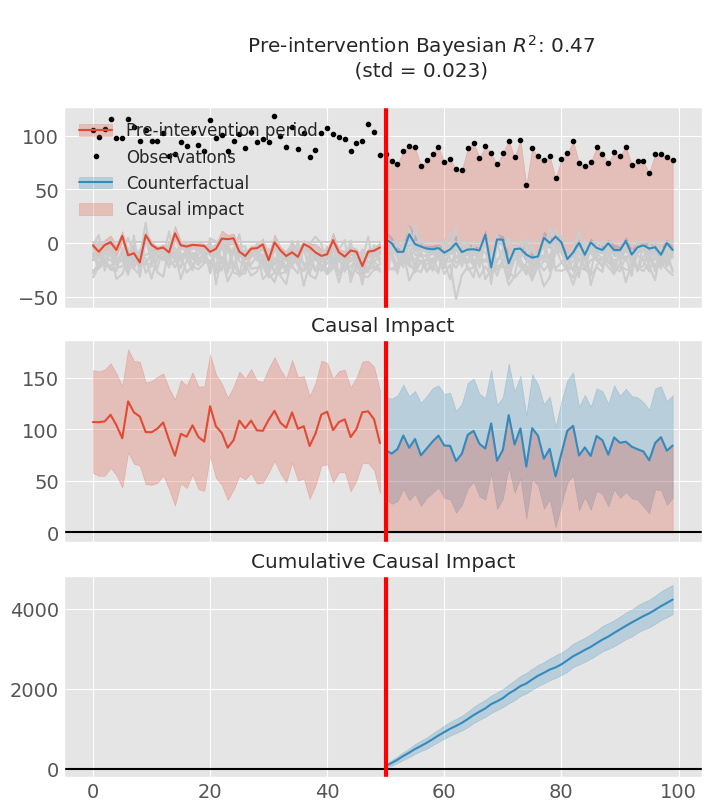

In [51]:
fig, ax = result_with_intercept.plot(plot_predictors=True)

In [53]:
data_bayes

,actual,a,b,c,d,e,f,g,h,i
0,104.967142,-27.899109,-15.929269,-25.609890,-31.930861,-2.298411,-3.990059,-15.808066,-9.278923,-12.324417
1,98.617357,-17.951854,-13.899298,-22.921750,-21.980335,7.533980,-20.781598,-0.090744,-23.822209,-19.944538
2,106.476885,-17.172546,-8.676631,-9.847003,-15.934148,-25.545862,-2.863886,-17.624273,-17.700554,-15.723702
3,115.230299,-21.768174,-8.969123,-11.216237,-15.516779,-5.930494,1.996433,-24.665449,-23.284514,-3.226631
4,97.658466,-15.358258,-33.283837,-17.528955,-20.487240,-18.066612,-7.425596,-26.147128,-23.006724,-14.100159
...,...,...,...,...,...,...,...,...,...,...
95,65.364851,-9.892227,-26.436239,-22.011696,-10.597484,-16.660350,-14.655410,-0.049308,-12.174663,-18.822153
96,82.961203,-22.583976,-10.511144,-34.451285,-26.359046,-14.258936,-8.298615,-10.976388,-20.332942,1.965715
97,82.610553,-12.208150,-16.434148,-3.781216,-17.889972,-21.347824,-24.071081,-3.765829,-17.194625,-9.602722
98,80.051135,-13.163314,-11.378522,-18.465338,-24.742767,-16.003119,-2.319675,-10.297652,-6.596672,-21.722940


In [69]:
from functools import partial

import numpy as np
from scipy.optimize import fmin_slsqp
from sklearn.base import RegressorMixin
from sklearn.linear_model._base import LinearModel


class WeightedProportion(LinearModel, RegressorMixin):
    """
    Model which minimises sum squared error subject to:

    - All weights are bound between 0-1
    - Weights sum to 1.
    - Optional intercept (unconstrained).

    Inspiration from:
    https://towardsdatascience.com/understanding-synthetic-control-methods-dd9a291885a1
    """

    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def loss(self, params, X, y):
        """Compute root mean squared loss with data X, weights, and intercept."""
        if self.fit_intercept:
            intercept, weights = params[0], params[1:]
            pred = intercept + np.dot(X, weights)
        else:
            pred = np.dot(X, params)
        return np.sqrt(np.mean((y - pred) ** 2))

    def fit(self, X, y):
        """Fit model on data X with predictor y."""
        w_start = [1 / X.shape[1]] * X.shape[1]
        if self.fit_intercept:
            params_start = np.array([np.mean(y)] + w_start)

            def eq_constraint(params):
                return np.sum(params[1:]) - 1

            bounds = [(None, None)] + [(0.0, 1.0)] * len(w_start)
        else:
            params_start = np.array(w_start)

            def eq_constraint(params):
                return np.sum(params) - 1

            bounds = [(0.0, 1.0)] * len(w_start)

        coef_ = fmin_slsqp(
            partial(self.loss, X=X, y=y),
            params_start,
            f_eqcons=eq_constraint,
            bounds=bounds,
            disp=False,
        )

        if self.fit_intercept:
            self.intercept_, self.coef_ = coef_[0], np.atleast_2d(coef_[1:])
        else:
            self.intercept_ = 0
            self.coef_ = np.atleast_2d(coef_)

        self.mse = self.loss(params=coef_, X=X, y=y)
        return self

    def predict(self, X):
        """Predict results for data X."""
        return self.intercept_ + np.dot(X, self.coef_.T)

# Example integration with causalpy SyntheticControl

import causalpy

result = causalpy.SyntheticControl(
    data_bayes,
    treatment_time=T0,
    formula="actual ~ 1 + a + b + c + d + e + f + g + h + i",
    model=WeightedProportion(fit_intercept=True),
)


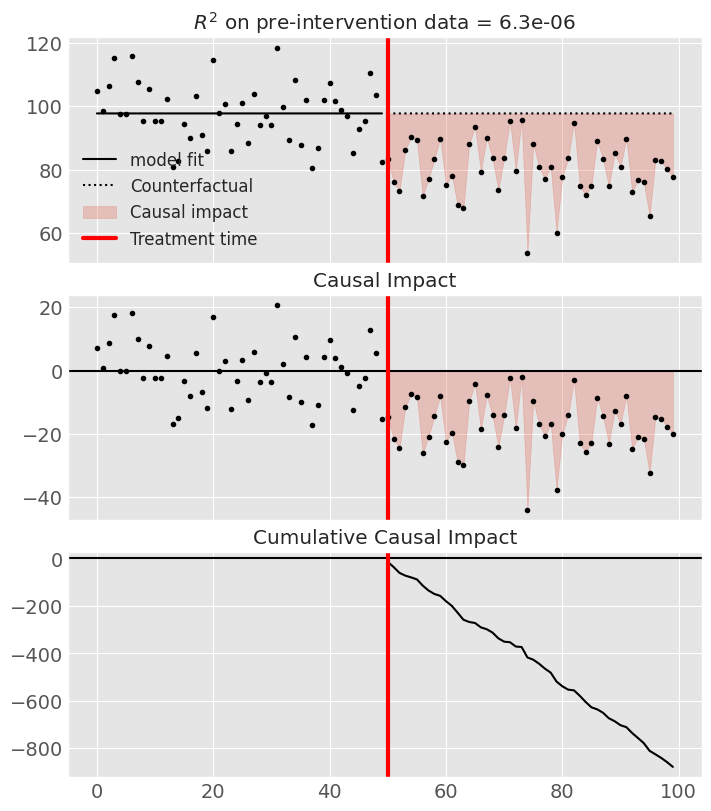

In [70]:
fig, ax = result.plot(plot_predictors=True)

In [64]:
result = causalpy.SyntheticControl(
    data_bayes,
    treatment_time = T0,
    formula="actual ~ 1 + a + b + c + d + e + f + g + h + i",
    model=causalpy.skl_models.WeightedProportion(),
)

In [68]:
result.

-0.17380236690573425

In [ ]:
result.summary(round_to=3)

==================================Pre-Post Fit==================================
Formula: actual ~ 0 + a + b + c + d + e + f + g + h + i
Model coefficients:
  a	    0.0996
  b	    0.0767
  c	     0.118
  d	    0.0536
  e	     0.199
  f	     0.101
  g	     0.123
  h	     0.166
  i	     0.063


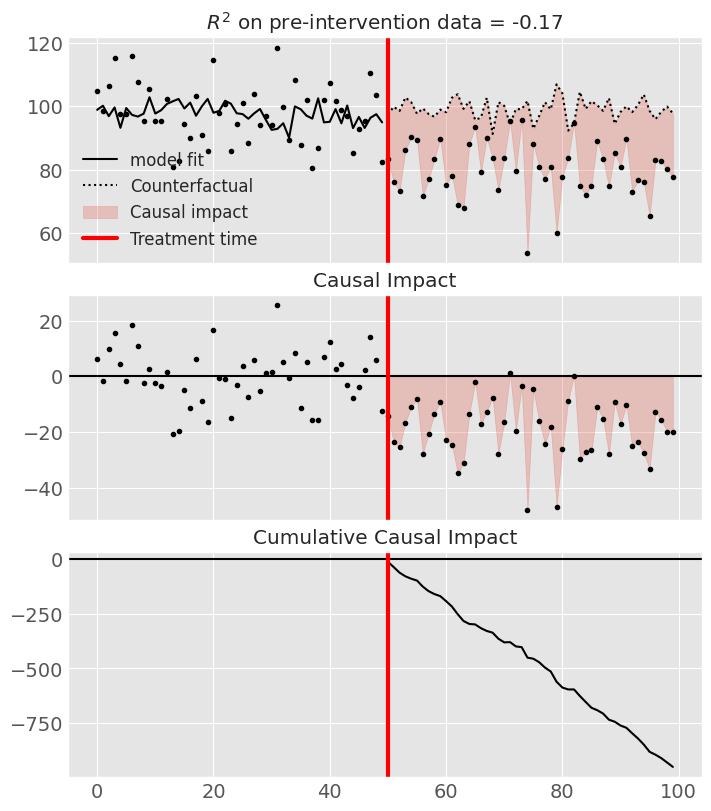

In [66]:
fig, ax = result.plot(plot_predictors=True)

In [47]:
result_with_intercept = causalpy.SyntheticControl(
    data_bayes,
    treatment_time = T0,
    formula="actual ~ 1 + a + b + c + d + e + f + g + h + i",
    model=causalpy.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

az.summary(result_with_intercept.post_impact.mean("obs_ind"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,80.316,3.691,73.658,87.317,0.058,0.041,4105.0,3723.0,1.0


In [50]:
result_with_intercept.summary()

==================================Pre-Post Fit==================================
Formula: actual ~ 1 + a + b + c + d + e + f + g + h + i
Model coefficients:
    Intercept  0.92, 94% HDI [0.87, 0.96]
    a          0.0089, 94% HDI [0.00024, 0.032]
    b          0.0075, 94% HDI [0.00022, 0.026]
    c          0.0074, 94% HDI [0.00018, 0.026]
    d          0.0079, 94% HDI [0.0002, 0.027]
    e          0.0089, 94% HDI [0.0003, 0.032]
    f          0.011, 94% HDI [0.00038, 0.039]
    g          0.01, 94% HDI [0.00033, 0.035]
    h          0.0072, 94% HDI [0.00016, 0.026]
    i          0.0083, 94% HDI [0.00023, 0.029]
    sigma      26, 94% HDI [25, 27]


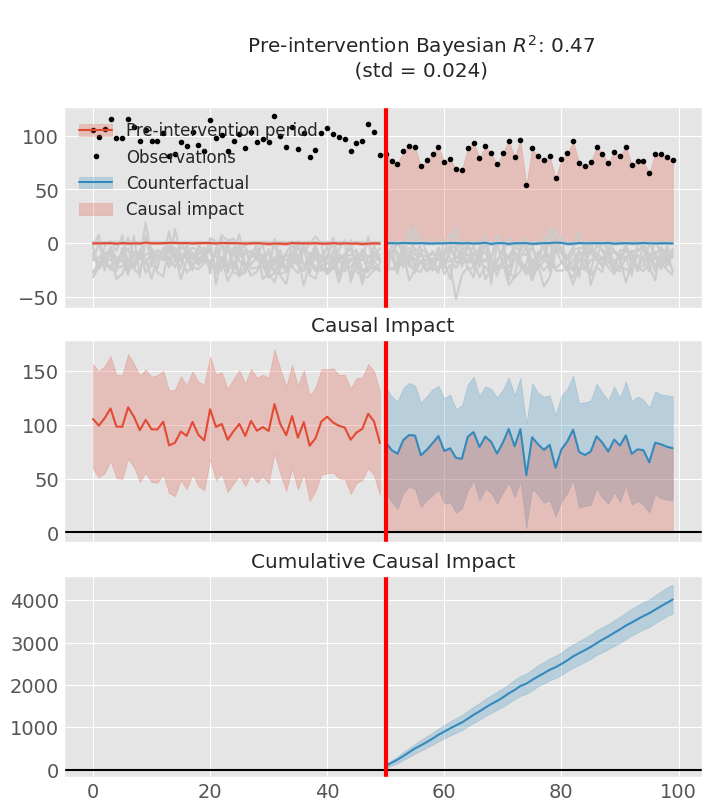

In [49]:
fig, ax = result_with_intercept.plot(plot_predictors=True)